In [34]:
import pandas as pd
import yaml
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
)
import numpy as np
from sim_utils.modeling import create_model, create_reg_model, update_config

In [35]:
pbp = pd.read_parquet("data/pbp.parquet")
pbp["year"] = pbp["game_id"].apply(lambda x: int(x.split("_")[0]))
small = pbp.loc[pbp.year > 2021].dropna(how="all", axis=1)
print(pbp.columns)

Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       ...
       'home_opening_kickoff', 'qb_epa', 'xyac_epa', 'xyac_mean_yardage',
       'xyac_median_yardage', 'xyac_success', 'xyac_fd', 'xpass', 'pass_oe',
       'year'],
      dtype='object', length=373)


In [36]:
desc_cols = [
    "play_id",
    "game_id",
    "home_team",
    "away_team",
    "game_half",
    "posteam",
    "side_of_field",
    "desc",
]


In [37]:
play_type_mapping = {
    "field_goal": 0,
    "no_play": 1,
    "pass": 2,
    "punt": 3,
    "qb_kneel": 4,
    "qb_spike": 5,
    "run": 6,
    np.nan: 7,
}

In [38]:
game_context_cols = [
    #'posteam',
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    # "yards_gained",
    "posteam_score",
    # "total_away_score",
    "score_differential",
    "quarter_seconds_remaining",
    "half_seconds_remaining",
    "game_seconds_remaining",
    "wind",
    "temp",
    "spread_line",
    "total_line",
]

pbp["play_type_enc"] = pbp["play_type"].map(play_type_mapping)
y_col = "play_type_enc"
data = pbp.loc[
    (~pbp.down.isna()) & (~pbp.rush_attempt.isna()) & ~(pbp.play_type.isna())
][game_context_cols + [y_col]]

In [39]:
team_receiver_stats = pd.read_csv("data/team_receiver_stats.csv", index_col=0)
receiver_cols = [x for x in team_receiver_stats.columns if "ception" in x] + [
    x for x in team_receiver_stats.columns if "arget" in x
] + [x for x in team_receiver_stats.columns if "ppr" in x] + [
    x for x in team_receiver_stats.columns if "pct" in x] + [
        x for x in team_receiver_stats.columns if "per_catch" in x
    ]
sorted(receiver_cols)

['fantasy_points_ppr_roll_RB_0',
 'fantasy_points_ppr_roll_RB_1',
 'fantasy_points_ppr_roll_TE_0',
 'fantasy_points_ppr_roll_TE_1',
 'fantasy_points_ppr_roll_TE_2',
 'fantasy_points_ppr_roll_WR_0',
 'fantasy_points_ppr_roll_WR_1',
 'fantasy_points_ppr_roll_WR_2',
 'fantasy_points_ppr_roll_WR_3',
 'fantasy_points_ppr_roll_WR_4',
 'offense_pct_roll_RB_0',
 'offense_pct_roll_RB_1',
 'offense_pct_roll_TE_0',
 'offense_pct_roll_TE_1',
 'offense_pct_roll_TE_2',
 'offense_pct_roll_WR_0',
 'offense_pct_roll_WR_1',
 'offense_pct_roll_WR_2',
 'offense_pct_roll_WR_3',
 'offense_pct_roll_WR_4',
 'receptions_roll_RB_0',
 'receptions_roll_RB_1',
 'receptions_roll_TE_0',
 'receptions_roll_TE_1',
 'receptions_roll_TE_2',
 'receptions_roll_WR_0',
 'receptions_roll_WR_1',
 'receptions_roll_WR_2',
 'receptions_roll_WR_3',
 'receptions_roll_WR_4',
 'target_share_roll_RB_0',
 'target_share_roll_RB_1',
 'target_share_roll_TE_0',
 'target_share_roll_TE_1',
 'target_share_roll_TE_2',
 'target_share_roll_WR_0'

In [40]:
team_receiver_stats

,team,season,week,gsis_id_WR_2,gsis_id_WR_3,gsis_id_WR_0,gsis_id_WR_1,gsis_id_WR_4,player_display_name_WR_2,player_display_name_WR_3,...,fantasy_points_ppr_roll_RB_1,fantasy_points_ppr_roll_RB_0,offense_snaps_roll_RB_1,offense_snaps_roll_RB_0,offense_pct_roll_RB_1,offense_pct_roll_RB_0,yards_per_catch_roll_RB_1,yards_per_catch_roll_RB_0,yards_per_target_roll_RB_1,yards_per_target_roll_RB_0
0,ARI,2013,1,00-0027691,00-0030300,00-0022921,00-0029638,NaN,Andre Roberts,Jaron Brown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARI,2013,2,00-0027691,00-0030300,00-0022921,00-0029638,NaN,Andre Roberts,Jaron Brown,...,NaN,7.400000,NaN,35.000000,NaN,0.490000,NaN,4.000000,NaN,4.000000
2,ARI,2013,3,00-0030300,00-0027691,00-0029638,00-0022921,NaN,Jaron Brown,Andre Roberts,...,9.100000,13.114286,13.714286,35.571429,0.190000,0.501429,18.818182,11.272727,12.176471,11.272727
3,ARI,2013,4,00-0030300,00-0027691,00-0029638,00-0022921,NaN,Jaron Brown,Andre Roberts,...,8.840541,9.648649,19.459459,30.135135,0.311081,0.457568,14.777778,11.510204,8.142857,11.510204
4,ARI,2013,5,00-0027691,NaN,00-0029638,00-0022921,NaN,Andre Roberts,NaN,...,3.582857,7.729143,13.331429,34.108571,0.204000,0.531600,6.142857,7.445428,2.948571,6.263027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5743,WAS,2024,20,00-0035659,NaN,00-0036626,NaN,00-0035208,Terry McLaurin,NaN,...,2.882656,7.799894,17.137838,36.331038,0.232920,0.505221,2.926605,6.227733,2.262521,5.218382
5744,WAS,2024,21,00-0036626,00-0035208,00-0035659,00-0039355,NaN,Dyami Brown,Olamide Zaccheaus,...,3.861995,10.774943,16.103375,37.248285,0.217190,0.511416,2.926605,6.227733,2.262521,5.218382
5745,WAS,2025,1,00-0033591,00-0039355,00-0035659,00-0035719,00-0040164,Noah Brown,Luke McCaffrey,...,NaN,11.648473,NaN,38.170744,NaN,0.571567,NaN,8.921856,NaN,7.076476
5746,WAS,2025,2,00-0033591,00-0040164,00-0035659,00-0035719,00-0039355,Noah Brown,Jaylin Lane,...,14.200000,10.911355,23.000000,36.878058,0.330000,0.546175,NaN,9.249458,0.000000,7.706270


In [41]:
team_rusher_cols = ['carries_roll_QB_0',
 'carries_roll_QB_1',
 'carries_roll_RB_0',
 'carries_roll_RB_1',
 'carries_roll_RB_2',
 'carries_roll_TE_0',
 'carries_roll_WR_0',
 'fantasy_points_ppr_roll_QB_0',
 'fantasy_points_ppr_roll_QB_1',
 'fantasy_points_ppr_roll_RB_0',
 'fantasy_points_ppr_roll_RB_1',
 'fantasy_points_ppr_roll_RB_2',
 'fantasy_points_ppr_roll_TE_0',
 'fantasy_points_ppr_roll_WR_0',
 'yards_per_carry_roll_QB_0',
 'yards_per_carry_roll_QB_1',
 'yards_per_carry_roll_RB_0',
 'yards_per_carry_roll_RB_1',
 'yards_per_carry_roll_RB_2',
 'yards_per_carry_roll_TE_0',
 'yards_per_carry_roll_WR_0',
 'offense_pct_roll_QB_0',
 'offense_pct_roll_QB_1',
 'offense_pct_roll_RB_0',
 'offense_pct_roll_RB_1',
 'offense_pct_roll_RB_2',
 'offense_pct_roll_TE_0',
 'offense_pct_roll_WR_0',
 'rushing_first_downs_roll_QB_0',
 'rushing_first_downs_roll_QB_1',
 'rushing_first_downs_roll_RB_0',
 'rushing_first_downs_roll_RB_1',
 'rushing_first_downs_roll_RB_2',
 'rushing_first_downs_roll_TE_0',
 'rushing_first_downs_roll_WR_0',
 'rushing_tds_roll_QB_0',
 'rushing_tds_roll_QB_1',
 'rushing_tds_roll_RB_0',
 'rushing_tds_roll_RB_1',
 'rushing_tds_roll_RB_2',
 'rushing_tds_roll_TE_0',
 'rushing_tds_roll_WR_0',
 'rushing_yards_roll_QB_0',
 'rushing_yards_roll_QB_1',
 'rushing_yards_roll_RB_0',
 'rushing_yards_roll_RB_1',
 'rushing_yards_roll_RB_2',
 'rushing_yards_roll_TE_0',
 'rushing_yards_roll_WR_0',
 'last_rusher_drive',
 'last_rusher_team']

In [42]:
def get_rusher_number(row):
    """0-2 is RB, 3-7 is WR, 8-10 is TE"""
    for num, col_name in enumerate(
        [
            "gsis_id_RB_0",
            "gsis_id_RB_1",
            "gsis_id_RB_2",
            "gsis_id_QB_0",
            "gsis_id_QB_1",
            "gsis_id_TE_0",
            "gsis_id_WR_0",
        ]
    ):
        if row[col_name] == row["rusher_player_id"]:
            return num
    return None

In [43]:
team_rb_stats = pd.read_csv("data/team_rushers.csv", index_col=0)
comb = pbp.merge(
    team_rb_stats,
    left_on=["posteam", "season", "week"],
    right_on=["team", "season", "week"],
)

comb["rusher_depth_num"] = comb.apply(get_rusher_number, axis=1)
rushes = comb.loc[(~comb.rusher_depth_num.isna()) & (~comb.yards_gained.isna())].copy(
    deep=True
)
rushes["last_rusher_drive"] = (
    rushes.groupby(["game_id", "drive", "posteam"])["rusher_depth_num"]
    .shift()
    .fillna(-1)
)
rushes["last_rusher_team"] = (
    rushes.groupby(["game_id", "posteam"])["rusher_depth_num"].shift().fillna(-1)
)
rushes[(game_context_cols + team_rusher_cols)]

,yardline_100,down,goal_to_go,ydstogo,posteam_score,score_differential,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,wind,...,rushing_tds_roll_WR_0,rushing_yards_roll_QB_0,rushing_yards_roll_QB_1,rushing_yards_roll_RB_0,rushing_yards_roll_RB_1,rushing_yards_roll_RB_2,rushing_yards_roll_TE_0,rushing_yards_roll_WR_0,last_rusher_drive,last_rusher_team
1,80.0,1.0,0.0,10.0,0.0,0.0,900.0,1800.0,3600.0,NaN,...,0.000000,0.000000,0.0,NaN,NaN,NaN,0.000000,0.000000e+00,-1.0,-1.0
2,77.0,2.0,0.0,7.0,0.0,0.0,864.0,1764.0,3564.0,NaN,...,0.000000,0.000000,0.0,NaN,NaN,NaN,0.000000,0.000000e+00,0.0,0.0
7,67.0,2.0,0.0,10.0,0.0,0.0,759.0,1659.0,3459.0,NaN,...,0.000000,0.000000,0.0,NaN,NaN,NaN,0.000000,0.000000e+00,-1.0,-1.0
12,66.0,2.0,0.0,5.0,0.0,0.0,614.0,1514.0,3314.0,NaN,...,0.000000,0.000000,0.0,NaN,NaN,NaN,0.000000,0.000000e+00,-1.0,0.0
14,10.0,1.0,1.0,10.0,0.0,0.0,553.0,1453.0,3253.0,NaN,...,0.000000,0.000000,0.0,NaN,NaN,NaN,0.000000,0.000000e+00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373100,25.0,3.0,0.0,2.0,14.0,0.0,240.0,240.0,240.0,NaN,...,0.000000,4.221979,0.0,35.948494,14.930717,NaN,0.000663,4.778409e-07,3.0,3.0
373101,21.0,1.0,0.0,10.0,14.0,0.0,195.0,195.0,195.0,NaN,...,0.000000,4.221979,0.0,35.948494,14.930717,NaN,0.000663,4.778409e-07,0.0,0.0
373110,52.0,2.0,0.0,2.0,14.0,-7.0,99.0,99.0,99.0,NaN,...,0.044495,23.570031,0.0,41.473646,17.285714,29.459334,0.000000,-8.449048e-02,-1.0,3.0
373115,71.0,1.0,0.0,10.0,21.0,7.0,63.0,63.0,63.0,NaN,...,0.000000,4.221979,0.0,35.948494,14.930717,NaN,0.000663,4.778409e-07,-1.0,0.0


In [44]:
rushes[['posteam','game_id', 'last_rusher_team', 'rusher_depth_num']].head(20)

,posteam,game_id,last_rusher_team,rusher_depth_num
1,ATL,2013_01_ATL_NO,-1.0,0.0
2,ATL,2013_01_ATL_NO,0.0,0.0
7,NO,2013_01_ATL_NO,-1.0,1.0
12,ATL,2013_01_ATL_NO,0.0,0.0
14,ATL,2013_01_ATL_NO,0.0,0.0
20,NO,2013_01_ATL_NO,1.0,0.0
23,NO,2013_01_ATL_NO,0.0,1.0
25,ATL,2013_01_ATL_NO,0.0,0.0
27,ATL,2013_01_ATL_NO,0.0,3.0
28,ATL,2013_01_ATL_NO,3.0,0.0


In [45]:
comb.loc[comb.rusher_player_name=='J.Hurts'][['home_team','season','week','rusher_player_id','rusher_depth_num', 'gsis_id_QB_0',
                                              'gsis_id_QB_1','desc']]

,home_team,season,week,rusher_player_id,rusher_depth_num,gsis_id_QB_0,gsis_id_QB_1,desc
213185,SF,2020,4,00-0036389,4.0,00-0032950,00-0036389,(1:24) #2 J.Hurts in at QB. (Shotgun) 2-J.Hurt...
213208,SF,2020,4,00-0036389,4.0,00-0032950,00-0036389,(9:58) 2-J.Hurts right end ran ob at SF 38 for...
213214,SF,2020,4,00-0036389,4.0,00-0032950,00-0036389,(6:39) (Shotgun) 2-J.Hurts FUMBLES (Aborted) a...
215223,PHI,2020,6,00-0036389,4.0,00-0032950,00-0036389,(5:32) (Shotgun) Direct snap to 2-J.Hurts. 2-J...
215225,PHI,2020,6,00-0036389,4.0,00-0032950,00-0036389,(4:06) (Shotgun) Direct snap to 2-J.Hurts. 2-J...
...,...,...,...,...,...,...,...,...
372390,PHI,2025,3,00-0036389,3.0,00-0036389,0,(:10) 1-J.Hurts kneels to PHI 34 for -1 yards.
372421,PHI,2025,3,00-0036389,3.0,00-0036389,0,(3:47) 1-J.Hurts up the middle to LA 10 for 1 ...
372449,PHI,2025,3,00-0036389,3.0,00-0036389,0,"(7:54) (No Huddle, Shotgun) 1-J.Hurts left end..."
372456,PHI,2025,3,00-0036389,3.0,00-0036389,0,"(4:40) (No Huddle, Shotgun) 1-J.Hurts left tac..."


In [46]:
rushes['rushing_yards_roll_RB_0'].max()

np.float64(184.0)

In [54]:
choose_rusher_cols = (
    game_context_cols + team_rusher_cols
)
choose_rusher_model = create_model(
    rushes.fillna(0), x_cols=choose_rusher_cols, y_col="rusher_depth_num"
)
joblib.dump(choose_rusher_model, "models/choose_rusher.joblib")
_ = """
Accuracy: 0.69
Confusion Matrix:
array([[17449,  1485,   433,   442,    45,     3,     4],
       [ 3336,  5003,   321,   309,    25,     1,     0],
       [ 1227,   518,  1998,   138,    12,     1,     0],
       [ 1857,   630,   241,  2019,    20,     0,     0],
       [  264,    91,    64,    98,   220,     0,     2],
       [   17,     4,     8,     2,     0,     7,     0],
       [  157,    45,    20,     8,     2,     0,     3]], dtype=int64)
"""

C:\Users\Sharedw\AppData\Local\Temp\ipykernel_4916\572941590.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rushes.fillna(0), x_cols=choose_rusher_cols, y_col="rusher_depth_num"


Accuracy: 0.68
Confusion Matrix:
[[9450  730  168  287   36    2    3]
 [2015 2548  151  184   25    0    2]
 [ 625  266  872   72   17    1    0]
 [1228  401  137 1236    9    1    0]
 [ 147   52   27   16  174    0    0]
 [   9    3    1    2    0    1    0]
 [ 113   42   11    9    1    0    3]]


In [56]:
rusher_idx_to_pos = {
    idx: col_name.split("id_")[-1]
    for idx, col_name in enumerate(
        [
            "gsis_id_RB_0",
            "gsis_id_RB_1",
            "gsis_id_RB_2",
            "gsis_id_QB_0",
            "gsis_id_QB_1",
            "gsis_id_TE_0",
            "gsis_id_WR_0",
        ]
    )
}
rusher_idx_to_pos

{0: 'RB_0', 1: 'RB_1', 2: 'RB_2', 3: 'QB_0', 4: 'QB_1', 5: 'TE_0', 6: 'WR_0'}

In [57]:
feature_config = {
    "choose_rusher_cols": choose_rusher_cols,
    'rusher_idx_to_pos': rusher_idx_to_pos
}
feature_config


{'choose_rusher_cols': ['yardline_100',
  'down',
  'goal_to_go',
  'ydstogo',
  'posteam_score',
  'score_differential',
  'quarter_seconds_remaining',
  'half_seconds_remaining',
  'game_seconds_remaining',
  'wind',
  'temp',
  'spread_line',
  'total_line',
  'carries_roll_QB_0',
  'carries_roll_QB_1',
  'carries_roll_RB_0',
  'carries_roll_RB_1',
  'carries_roll_RB_2',
  'carries_roll_TE_0',
  'carries_roll_WR_0',
  'fantasy_points_ppr_roll_QB_0',
  'fantasy_points_ppr_roll_QB_1',
  'fantasy_points_ppr_roll_RB_0',
  'fantasy_points_ppr_roll_RB_1',
  'fantasy_points_ppr_roll_RB_2',
  'fantasy_points_ppr_roll_TE_0',
  'fantasy_points_ppr_roll_WR_0',
  'yards_per_carry_roll_QB_0',
  'yards_per_carry_roll_QB_1',
  'yards_per_carry_roll_RB_0',
  'yards_per_carry_roll_RB_1',
  'yards_per_carry_roll_RB_2',
  'yards_per_carry_roll_TE_0',
  'yards_per_carry_roll_WR_0',
  'offense_pct_roll_QB_0',
  'offense_pct_roll_QB_1',
  'offense_pct_roll_RB_0',
  'offense_pct_roll_RB_1',
  'offense_pct

In [58]:
update_config(feature_config)

In [60]:
passes = pbp.loc[(~pbp.receiver_player_id.isna()) & (pbp.play_type_enc == 2)].copy(
    deep=True
)
passes = passes.merge(
    team_receiver_stats,
    left_on=["posteam", "season", "week"],
    right_on=["team", "season", "week"],
)
passes.sample(3)


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,fantasy_points_ppr_roll_RB_1,fantasy_points_ppr_roll_RB_0,offense_snaps_roll_RB_1,offense_snaps_roll_RB_0,offense_pct_roll_RB_1,offense_pct_roll_RB_0,yards_per_catch_roll_RB_1,yards_per_catch_roll_RB_0,yards_per_target_roll_RB_1,yards_per_target_roll_RB_0
161422,3662.0,2023_06_CAR_MIA,2023101507,MIA,CAR,REG,6,CAR,away,MIA,...,6.786298,NaN,31.283703,NaN,0.454065,NaN,5.932573,NaN,4.765479,NaN
39079,3598.0,2015_10_HOU_CIN,2015111600,CIN,HOU,REG,10,HOU,away,CIN,...,4.296361,7.028577,17.930705,21.705877,0.235411,0.290636,6.328390,6.843980,4.673520,6.622452
163941,2318.0,2023_08_TB_BUF,2023102600,BUF,TB,REG,8,BUF,home,TB,...,6.330831,12.095636,25.325878,33.569614,0.383891,0.509897,7.806314,12.534182,6.998397,10.630122


In [61]:
def get_receiver_number(row):
    """0-2 is RB, 3-7 is WR, 8-10 is TE"""
    for num, col_name in enumerate(
        [
            "gsis_id_WR_0",
            "gsis_id_WR_1",
            "gsis_id_WR_2",
            "gsis_id_WR_3",
            "gsis_id_WR_4",
            "gsis_id_TE_0",
            "gsis_id_TE_1",
            "gsis_id_TE_2",
            "gsis_id_RB_0",
            "gsis_id_RB_1",
        ]
    ):
        if row[col_name] == row["receiver_player_id"]:
            return num
    return None


In [62]:
receiver_idx_to_pos = {
    idx: col_name.split("id_")[-1]
    for idx, col_name in enumerate(
        [
            "gsis_id_WR_0",
            "gsis_id_WR_1",
            "gsis_id_WR_2",
            "gsis_id_WR_3",
            "gsis_id_WR_4",
            "gsis_id_TE_0",
            "gsis_id_TE_1",
            "gsis_id_TE_2",
            "gsis_id_RB_0",
            "gsis_id_RB_1",
        ]
    )
}
receiver_idx_to_pos


{0: 'WR_0',
 1: 'WR_1',
 2: 'WR_2',
 3: 'WR_3',
 4: 'WR_4',
 5: 'TE_0',
 6: 'TE_1',
 7: 'TE_2',
 8: 'RB_0',
 9: 'RB_1'}

In [63]:
passes["receiver_idx"] = passes.apply(get_receiver_number, axis=1)
passes[
    [
        "posteam",
        "gsis_id_WR_0",
        "gsis_id_WR_1",
        "gsis_id_WR_2",
        "gsis_id_WR_3",
        "gsis_id_WR_4",
        "gsis_id_TE_0",
        "gsis_id_TE_1",
        "gsis_id_TE_2",
        "gsis_id_RB_0",
        "gsis_id_RB_1",
        "receiver_player_id",
        "receiver_idx",
    ]
]


,posteam,gsis_id_WR_0,gsis_id_WR_1,gsis_id_WR_2,gsis_id_WR_3,gsis_id_WR_4,gsis_id_TE_0,gsis_id_TE_1,gsis_id_TE_2,gsis_id_RB_0,gsis_id_RB_1,receiver_player_id,receiver_idx
0,ARI,00-0022921,00-0029638,00-0027691,00-0030300,NaN,NaN,00-0027825,00-0026757,00-0026163,00-0030287,00-0027825,6.0
1,ARI,00-0022921,00-0029638,00-0027691,00-0030300,NaN,NaN,00-0027825,00-0026757,00-0026163,00-0030287,00-0029638,1.0
2,ARI,00-0022921,00-0029638,00-0027691,00-0030300,NaN,NaN,00-0027825,00-0026757,00-0026163,00-0030287,00-0022921,0.0
3,ARI,00-0022921,00-0029638,00-0027691,00-0030300,NaN,NaN,00-0027825,00-0026757,00-0026163,00-0030287,00-0022921,0.0
4,ARI,00-0022921,00-0029638,00-0027691,00-0030300,NaN,NaN,00-0027825,00-0026757,00-0026163,00-0030287,00-0026757,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193443,NE,00-0031588,00-0038608,00-0033555,00-0038621,00-0040131,00-0033090,00-0032392,NaN,00-0036875,00-0040734,00-0033090,5.0
193444,NE,00-0031588,00-0038608,00-0033555,00-0038621,00-0040131,00-0033090,00-0032392,NaN,00-0036875,00-0040734,00-0040734,9.0
193445,NE,00-0031588,00-0038608,00-0033555,00-0038621,00-0040131,00-0033090,00-0032392,NaN,00-0036875,00-0040734,00-0038621,3.0
193446,NE,00-0031588,00-0038608,00-0033555,00-0038621,00-0040131,00-0033090,00-0032392,NaN,00-0036875,00-0040734,00-0033090,5.0


In [64]:
team_receiver_stats[
    [
        "gsis_id_WR_0",
        "gsis_id_WR_1",
        "gsis_id_WR_2",
        "gsis_id_WR_3",
        "gsis_id_WR_4",
        "gsis_id_TE_0",
        "gsis_id_TE_1",
        "gsis_id_TE_2",
        "gsis_id_RB_0",
        "gsis_id_RB_1",
    ]
]


,gsis_id_WR_0,gsis_id_WR_1,gsis_id_WR_2,gsis_id_WR_3,gsis_id_WR_4,gsis_id_TE_0,gsis_id_TE_1,gsis_id_TE_2,gsis_id_RB_0,gsis_id_RB_1
0,00-0022921,00-0029638,00-0027691,00-0030300,NaN,NaN,00-0027825,00-0026757,00-0026163,00-0030287
1,00-0022921,00-0029638,00-0027691,00-0030300,NaN,00-0027825,NaN,NaN,00-0026163,00-0030282
2,00-0029638,00-0022921,00-0030300,00-0027691,NaN,00-0028007,NaN,NaN,00-0026163,00-0030287
3,00-0029638,00-0022921,00-0030300,00-0027691,NaN,00-0028007,00-0027825,NaN,00-0026163,00-0030287
4,00-0029638,00-0022921,00-0027691,NaN,NaN,00-0027825,00-0028007,NaN,00-0026163,00-0027346
...,...,...,...,...,...,...,...,...,...,...
5743,00-0036626,NaN,00-0035659,NaN,00-0035208,00-0030061,00-0036628,NaN,00-0037746,00-0033955
5744,00-0035659,00-0039355,00-0036626,00-0035208,NaN,00-0030061,00-0036628,00-0039912,00-0037746,00-0033955
5745,00-0035659,00-0035719,00-0033591,00-0039355,00-0040164,00-0030061,NaN,NaN,00-0033699,00-0040242
5746,00-0035659,00-0035719,00-0033591,00-0040164,00-0039355,00-0030061,NaN,00-0039912,00-0033699,00-0040242


In [65]:
choose_receiver_cols = game_context_cols + receiver_cols
choose_receiver_model = create_model(
    passes, x_cols=choose_receiver_cols, y_col="receiver_idx", colsample_bytree=0.6
)
joblib.dump(choose_receiver_model, "models/choose_receiver.joblib")
#0.26
_ = '''
array([[4621, 2668,  719,  239,  101,  980,  172,   67,  248,  151],
       [2879, 4241,  792,  264,   95,  888,  201,   58,  231,  149],
       [1544, 1506, 1167,  150,   83,  577,  106,   25,  146,   80],
       [1168, 1020,  231,  351,   49,  443,   96,   35,  112,   76],
       [ 495,  432,  172,   55,  168,  214,   29,   11,   55,   36],
       [2133, 1924,  528,  206,   81, 1390,   76,   28,  186,  114],
       [1037,  975,  239,   86,   51,  270,  237,   13,   82,   69],
       [ 347,  354,  101,   38,   15,  119,   43,   58,   30,   25],
       [1605, 1499,  397,  124,   55,  472,  110,   32,  339,   43],
       [ 945,  874,  308,  126,   35,  386,   67,   28,   57,  232]],
      dtype=int64)
      '''

Accuracy: 0.26
Confusion Matrix:
[[3154 1777  562  155   76  762  140   32  197  102]
 [1999 2961  531  170   69  701  152   62  184  102]
 [1163 1060  924  101   48  483  114   25  144   75]
 [ 732  686  161  203   38  331   68   14  112   60]
 [ 298  308  145   40   99  145   38   10   46   21]
 [1479 1375  456   96   62  969   58   15  170   80]
 [ 717  663  202   73   26  198  178   20   65   39]
 [ 274  222   53   25   17   61   28   31   26   14]
 [1181 1036  296   90   54  315   84   18  290   30]
 [ 702  616  229   78   28  245   61   26   56  171]]


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

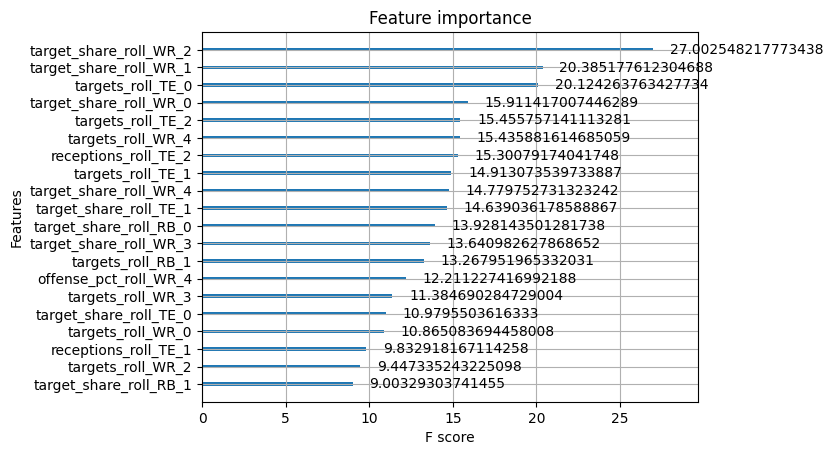

In [66]:
xgb.plot_importance(choose_receiver_model, importance_type="gain", max_num_features=20)

In [67]:
feature_config = {}
feature_config["receiver_idx_to_pos"] =  receiver_idx_to_pos
feature_config['choose_receiver_cols'] = choose_receiver_cols


In [68]:
feature_config.keys()

dict_keys(['receiver_idx_to_pos', 'choose_receiver_cols'])

In [69]:
update_config(feature_config)

In [113]:
player_context = [
    "season",
    'player_display_name',
    "team",
    "week",
    "gsis_id",
    "position",
]

In [114]:
receiver_cols = [
    "dense_depth",
 'receptions_roll',
 'targets_roll',
 'receiving_yards_roll',
 'receiving_tds_roll',
 'fantasy_points_ppr_roll',
 'yards_per_catch_roll',
 'yards_per_target_roll',
 'passing_first_downs_roll',
 'offense_pct_roll']

receiver_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet')
receiver_stats[receiver_cols+player_context]

,dense_depth,receptions_roll,targets_roll,receiving_yards_roll,receiving_tds_roll,fantasy_points_ppr_roll,yards_per_catch_roll,yards_per_target_roll,passing_first_downs_roll,offense_pct_roll,season,player_display_name,team,week,gsis_id,position
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,Geno Smith,NYJ,1,00-0030565,QB
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,Cordarrelle Patterson,MIN,1,00-0030578,WR
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,DeAndre Hopkins,HOU,1,00-0030564,WR
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,Ace Sanders,JAX,1,00-0030550,WR
4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013,Tyler Eifert,CIN,1,00-0030549,TE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64419,0,1.895721e-07,1.895721e-07,-7.598847e-07,0.000000e+00,16.407495,3.999998,6.999998,10.072956,0.947033,2025,Aaron Rodgers,PIT,3,00-0023459,QB
64420,2,2.432197e+00,3.717773e+00,2.854984e+01,1.475266e-01,6.549934,9.483676,7.535301,0.000000,0.722463,2025,Adam Thielen,MIN,3,00-0030035,WR
64421,0,1.335330e+00,1.867896e+00,1.840007e+01,2.465694e-01,4.701293,9.591823,8.856691,0.000000,0.371390,2025,Kyle Juszczyk,SF,3,00-0029892,FB
64422,0,2.514146e-06,2.514146e-06,2.514145e-06,8.054281e-18,18.616664,3.999992,6.999985,10.703586,0.980082,2025,Russell Wilson,NYG,3,00-0029263,QB


In [115]:
receiver_stats.iloc[5]

dense_depth                                       3
position                                         RB
gsis_id                                  00-0030547
game_id                              2013_01_KC_JAX
season                                         2013
week                                              1
player_id                                00-0030547
player_display_name                 Denard Robinson
team                                            JAX
opponent                                         KC
offense_snaps                                   6.0
offense_pct                                    0.08
attempts_roll                                   NaN
receiving_yards_after_catch_roll                NaN
target_share_roll                               NaN
passing_yards_roll                              NaN
passing_tds_roll                                NaN
receiving_tds_roll                              NaN
offense_pct_roll                                NaN
completions_

In [116]:
qb_cols = [
    'dense_depth',
    "passing_yards_roll",
    "fantasy_points_ppr_roll",
    "sacks_suffered_roll",
    "passing_yards_after_catch_roll",
    "passing_interceptions_roll",
    "passing_tds_roll",
    "offense_pct_roll",
    "passing_air_yards_roll",
    "receiving_air_yards_roll",
    "passing_first_downs_roll",
    "sack_yards_lost_roll",
    "completion_pct_roll"
]
qb_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet', columns=qb_cols+player_context)
qb_stats.loc[qb_stats.player_display_name == 'Patrick Mahomes']

,dense_depth,passing_yards_roll,fantasy_points_ppr_roll,sacks_suffered_roll,passing_yards_after_catch_roll,passing_interceptions_roll,passing_tds_roll,offense_pct_roll,passing_air_yards_roll,receiving_air_yards_roll,passing_first_downs_roll,sack_yards_lost_roll,completion_pct_roll,season,player_display_name,team,week,gsis_id,position
25268,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,Patrick Mahomes,KC,17,00-0033873,QB
25840,0,284.000000,10.360000,2.000000,174.000000,1.000000,0.000000,0.940000,261.000000,0.000000,14.000000,-15.000000,0.628571,2018,Patrick Mahomes,KC,1,00-0033873,QB
26103,0,268.000000,20.634286,1.428571,139.142857,0.428571,2.285714,0.974286,312.428571,0.000000,11.714286,-6.428571,0.591549,2018,Patrick Mahomes,KC,2,00-0033873,QB
26364,0,293.081081,28.507027,1.243243,131.729730,0.243243,3.891892,0.985405,307.918919,0.000000,14.000000,-5.378378,0.686293,2018,Patrick Mahomes,KC,3,00-0033873,QB
26530,0,300.731429,27.319543,1.520000,149.382857,0.154286,3.565714,0.990743,335.742857,0.000000,14.365714,-5.971429,0.662919,2018,Patrick Mahomes,KC,4,00-0033873,QB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63412,0,236.573139,18.636878,1.983569,136.639378,0.133236,1.680912,0.988394,229.604590,-0.002523,12.170377,-12.144293,0.663161,2024,Patrick Mahomes,KC,21,00-0033873,QB
63439,0,238.679854,21.502659,1.987677,137.729534,0.099927,1.510684,0.991295,220.453443,-0.001892,12.627783,-12.108220,0.668901,2024,Patrick Mahomes,KC,22,00-0033873,QB
63493,0,243.259891,21.821994,2.990758,125.797150,0.574945,1.883013,0.993471,226.840082,-0.001419,12.220837,-16.831165,0.665811,2025,Patrick Mahomes,KC,1,00-0033873,QB
63919,0,246.944918,22.871495,2.743068,123.347863,0.431209,1.662260,0.995104,237.880062,-0.001064,11.415628,-14.873374,0.651484,2025,Patrick Mahomes,KC,2,00-0033873,QB


In [117]:
qb_stats.columns = [x + '_qb'  if x in qb_cols else x for x in qb_stats.columns]
qb_cols = [x + '_qb' for x in qb_cols]

In [118]:
passes = pbp.loc[(~pbp.receiver_player_id.isna()) & (pbp.play_type_enc == 2)].copy(
    deep=True
)
passes = passes.merge(
    qb_stats,
    left_on=["posteam", "season", "week", "passer_player_id"],
    right_on=["team", "season", "week", 'gsis_id'],
)
passes = passes.merge(
    receiver_stats,
    left_on=["posteam", "season", "week", "receiver_player_id"],
    right_on=["team", "season", "week", 'gsis_id'],
    suffixes=('_qb','')
)
passes

,play_id,game_id_qb,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,rushing_yards_roll,sacks_suffered_roll,carries_roll,passing_2pt_conversions_roll,receiving_first_downs_roll,sack_yards_lost_roll,completion_pct_roll,yards_per_carry_roll,yards_per_catch_roll,yards_per_target_roll
0,299.0,2013_01_ARI_STL,2013090810,LA,ARI,REG,1,ARI,away,LA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,323.0,2013_01_ARI_STL,2013090810,LA,ARI,REG,1,ARI,away,LA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,418.0,2013_01_ARI_STL,2013090810,LA,ARI,REG,1,ARI,away,LA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,727.0,2013_01_ARI_STL,2013090810,LA,ARI,REG,1,ARI,away,LA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,751.0,2013_01_ARI_STL,2013090810,LA,ARI,REG,1,ARI,away,LA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205590,3846.0,2025_03_PIT_NE,2025092104,NE,PIT,REG,3,NE,home,PIT,...,0.000000,0.0,0.000000,0.0,1.776468,0.0,NaN,3.000000,9.374503,6.242714
205591,3871.0,2025_03_PIT_NE,2025092104,NE,PIT,REG,3,NE,home,PIT,...,17.285714,0.0,3.857143,0.0,1.142857,0.0,NaN,4.176471,6.666667,7.303030
205592,3950.0,2025_03_PIT_NE,2025092104,NE,PIT,REG,3,NE,home,PIT,...,1.297219,0.0,0.307729,0.0,1.293564,0.0,NaN,3.286015,6.936673,5.523183
205593,3980.0,2025_03_PIT_NE,2025092104,NE,PIT,REG,3,NE,home,PIT,...,0.000000,0.0,0.000000,0.0,1.776468,0.0,NaN,3.000000,9.374503,6.242714


In [119]:
completion_features = game_context_cols + qb_cols + receiver_cols + ['air_yards']
completion_features

['yardline_100',
 'down',
 'goal_to_go',
 'ydstogo',
 'posteam_score',
 'score_differential',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'wind',
 'temp',
 'spread_line',
 'total_line',
 'dense_depth_qb',
 'passing_yards_roll_qb',
 'fantasy_points_ppr_roll_qb',
 'sacks_suffered_roll_qb',
 'passing_yards_after_catch_roll_qb',
 'passing_interceptions_roll_qb',
 'passing_tds_roll_qb',
 'offense_pct_roll_qb',
 'passing_air_yards_roll_qb',
 'receiving_air_yards_roll_qb',
 'passing_first_downs_roll_qb',
 'sack_yards_lost_roll_qb',
 'completion_pct_roll_qb',
 'dense_depth',
 'receptions_roll',
 'targets_roll',
 'receiving_yards_roll',
 'receiving_tds_roll',
 'fantasy_points_ppr_roll',
 'yards_per_catch_roll',
 'yards_per_target_roll',
 'passing_first_downs_roll',
 'offense_pct_roll',
 'air_yards']

In [120]:
passes[completion_features]

,yardline_100,down,goal_to_go,ydstogo,posteam_score,score_differential,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,wind,...,receptions_roll,targets_roll,receiving_yards_roll,receiving_tds_roll,fantasy_points_ppr_roll,yards_per_catch_roll,yards_per_target_roll,passing_first_downs_roll,offense_pct_roll,air_yards
0,80.0,2.0,0.0,10.0,0.0,0.0,653.0,1553.0,3353.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0
1,70.0,1.0,0.0,10.0,0.0,0.0,622.0,1522.0,3322.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0
2,41.0,2.0,0.0,10.0,0.0,0.0,487.0,1387.0,3187.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
3,72.0,3.0,0.0,2.0,0.0,0.0,76.0,976.0,2776.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
4,67.0,1.0,0.0,10.0,0.0,0.0,41.0,941.0,2741.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205590,66.0,2.0,0.0,2.0,14.0,-7.0,127.0,127.0,127.0,NaN,...,2.984130,5.463414,33.349244,0.117472,7.023885,9.374503,6.242714,0.0,0.815882,6.0
205591,60.0,1.0,0.0,10.0,14.0,-7.0,120.0,120.0,120.0,NaN,...,3.714286,3.714286,27.428571,0.000000,8.185714,6.666667,7.303030,0.0,0.332857,0.0
205592,40.0,2.0,0.0,13.0,14.0,-7.0,85.0,85.0,85.0,NaN,...,2.732355,4.230703,21.890127,0.358270,7.200622,6.936673,5.523183,0.0,0.573724,5.0
205593,40.0,3.0,0.0,13.0,14.0,-7.0,81.0,81.0,81.0,NaN,...,2.984130,5.463414,33.349244,0.117472,7.023885,9.374503,6.242714,0.0,0.815882,12.0


In [121]:
def create_model(df, x_cols, y_col, colsample_bytree=0.5):
    data = df.loc[~(df[y_col].isna())].copy(deep=True)
    X, y = data[x_cols], data[y_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = xgb.XGBClassifier(eval_metric="mlogloss", colsample_bytree=colsample_bytree)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    display(cm)
    return model

In [122]:
completion_df = passes.loc[~passes.offense_pct_roll.isna()].copy()[completion_features + ['complete_pass']]#.dropna()
#231174

In [124]:
complete_pass_model = create_model(
    completion_df, x_cols=completion_features, y_col="complete_pass", colsample_bytree=0.6
)
joblib.dump(complete_pass_model, "models/complete_pass.joblib")

Accuracy: 0.70
Confusion Matrix:


array([[ 4742,  9108],
       [ 2936, 23483]])

['models/complete_pass.joblib']

In [125]:
feature_config = {
    "complete_pass_cols": completion_features,
}
feature_config

update_config(feature_config)

In [126]:
passes.loc[passes.air_yards > 40]['complete_pass'].value_counts(normalize=True)

complete_pass
0.0    0.709981
1.0    0.290019
Name: proportion, dtype: float64